### Download the dataset

In [ ]:
#! wget https://kh3-ls-storage.s3.us-east-1.amazonaws.com/Updated%20Project%20guide%20data%20set/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET.zip

### Unzip the Data

In [ ]:
#! unzip FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET.zip -d data/

### Installing packages

In [2]:
! pip install -r requirements.txt

  Using cached np_utils-0.6.0-py3-none-any.whl
  Using cached dask-2024.3.1-py3-none-any.whl (1.2 MB)
  Using cached scikeras-0.12.0-py3-none-any.whl (27 kB)
  Using cached toolz-0.12.1-py3-none-any.whl (56 kB)
  Using cached partd-1.4.1-py3-none-any.whl (18 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Importing Packages

In [3]:
## General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## OS and Path
import os
import os.path
from pathlib import Path
import glob

## Image Processing
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

## Scaling and Transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## Accuracy and Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

## TensorFlow Keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam,Optimizer
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

## Model Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from PIL import Image
import plotly.graph_objects as go

## Ignore Warnings
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

2024-03-23 19:36:41.067961: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 19:36:41.121871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
## Clearing Any Previous Session
tf.keras.backend.clear_session()

In [5]:
## Check TF version and no of GPU instances
tf.__version__, tf.config.list_physical_devices('GPU')

2024-03-23 19:36:45.739930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:36:45.772214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:36:45.774161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

('2.12.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

### Read Data

In [6]:
## Set traning data folder
fire_dataset_train_path = Path("data/train/")

## Set test data folder
fire_dataset_test_path = Path("data/test/")

In [7]:
## Save Training images path in a list
image_path_train = list(fire_dataset_train_path.glob(r"*/*"))

In [8]:
## Save Test images path in a list
image_path_test = list(fire_dataset_test_path.glob(r"*/*"))

In [9]:
## Extract labels for files based on their folder structure for training and test data
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],image_path_train))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],image_path_test))

In [10]:
## Print the labels and the count for each label in training data
print("Fire: ", train_labels.count("fire"))
print("Non_Fire: ", train_labels.count("non fire"))
print("Smoke: ", train_labels.count("Smoke"))

Fire:  10800
Non_Fire:  10800
Smoke:  10801


In [11]:
## Print the labels and the count for each label in test data
print("Fire: ", test_labels.count("fire"))
print("Non_Fire: ", test_labels.count("non fire"))
print("Smoke: ", test_labels.count("Smoke"))

Fire:  3500
Non_Fire:  3500
Smoke:  3501


We can see Data is non skewed and all the categories have equal no of images

In [12]:
## Convert traning data into two Series, one for image files and other for labels/category
train_path_series = pd.Series(image_path_train,name="Files").astype(str)
train_labels_series = pd.Series(train_labels,name="Category")

In [13]:
## Convert test data into a Series, one for image files and other for labels/category
test_path_series = pd.Series(image_path_test,name="Files").astype(str)
test_labels_series = pd.Series(test_labels,name="Category")

In [14]:
## Print training series
print(train_path_series)
print(train_labels_series)

0          data/train/fire/Fire (8011).jpg
1          data/train/fire/Fire (3007).jpg
2          data/train/fire/Fire (5894).jpg
3           data/train/fire/Fire (343).jpg
4          data/train/fire/Fire (6947).jpg
                       ...                
32396    data/train/Smoke/Smoke (3652).jpg
32397    data/train/Smoke/Smoke (2923).jpg
32398     data/train/Smoke/Smoke (572).tif
32399    data/train/Smoke/Smoke (4381).jpg
32400    data/train/Smoke/Smoke (7216).jpg
Name: Files, Length: 32401, dtype: object
0         fire
1         fire
2         fire
3         fire
4         fire
         ...  
32396    Smoke
32397    Smoke
32398    Smoke
32399    Smoke
32400    Smoke
Name: Category, Length: 32401, dtype: object


In [15]:
## Print test series
print(test_path_series)
print(test_labels_series)

0           data/test/fire/Fire (343).jpg
1          data/test/fire/Fire (1225).jpg
2           data/test/fire/Fire (598).png
3           data/test/fire/Fire (505).jpg
4          data/test/fire/Fire (1063).jpg
                       ...               
10496     data/test/Smoke/Smoke (734).tif
10497     data/test/Smoke/Smoke (844).jpg
10498    data/test/Smoke/Smoke (1870).jpg
10499    data/test/Smoke/Smoke (1159).jpg
10500     data/test/Smoke/Smoke (572).tif
Name: Files, Length: 10501, dtype: object
0         fire
1         fire
2         fire
3         fire
4         fire
         ...  
10496    Smoke
10497    Smoke
10498    Smoke
10499    Smoke
10500    Smoke
Name: Category, Length: 10501, dtype: object


In [16]:
## Replacing Names of category to be more readable
train_labels_series.replace({"non fire":"No_Fire","fire":"Fire"},inplace=True)

In [17]:
test_labels_series.replace({"non fire":"No_Fire","fire":"Fire"},inplace=True)

In [18]:
## Creating a dataframe with training data
train_data = pd.concat([train_path_series, train_labels_series],axis=1)

In [19]:
## Creating a dataframe with test data
test_data = pd.concat([test_path_series, test_labels_series],axis=1)

In [20]:
## Remove Smoke Data since it's leading to be identified as Fire and decreasing the overall efficiency of the model
train_data = train_data[train_data.Category != "Smoke"]
test_data = test_data[test_data.Category != "Smoke"]

print(train_data)
print(test_data)

                                         Files Category
0              data/train/fire/Fire (8011).jpg     Fire
1              data/train/fire/Fire (3007).jpg     Fire
2              data/train/fire/Fire (5894).jpg     Fire
3               data/train/fire/Fire (343).jpg     Fire
4              data/train/fire/Fire (6947).jpg     Fire
...                                        ...      ...
21595  data/train/non fire/Non_Fire (6171).jpg  No_Fire
21596  data/train/non fire/Non_Fire (5442).jpg  No_Fire
21597  data/train/non fire/Non_Fire (2931).jpg  No_Fire
21598  data/train/non fire/Non_Fire (3660).jpg  No_Fire
21599  data/train/non fire/Non_Fire (7224).jpg  No_Fire

[21600 rows x 2 columns]
                                       Files Category
0              data/test/fire/Fire (343).jpg     Fire
1             data/test/fire/Fire (1225).jpg     Fire
2              data/test/fire/Fire (598).png     Fire
3              data/test/fire/Fire (505).jpg     Fire
4             data/test/fire/Fir

In [21]:
# Randomly sample 30% of your train dataframe
train_data = train_data.sample(frac=0.3, ignore_index=True)

# Randomly sample 30% of your test dataframe
test_data = test_data.sample(frac=0.3, ignore_index=True)

In [22]:
train_data

Files Category
0      data/train/non fire/Non_Fire (504).jpg  No_Fire
1             data/train/fire/Fire (6891).jpg     Fire
2     data/train/non fire/Non_Fire (7884).jpg  No_Fire
3             data/train/fire/Fire (6279).jpg     Fire
4      data/train/non fire/Non_Fire (229).png  No_Fire
...                                       ...      ...
6475  data/train/non fire/Non_Fire (3288).jpg  No_Fire
6476  data/train/non fire/Non_Fire (5895).jpg  No_Fire
6477          data/train/fire/Fire (2799).jpg     Fire
6478  data/train/non fire/Non_Fire (4678).jpg  No_Fire
6479  data/train/non fire/Non_Fire (3852).jpg  No_Fire

[6480 rows x 2 columns]

In [23]:
plt.style.use("dark_background")

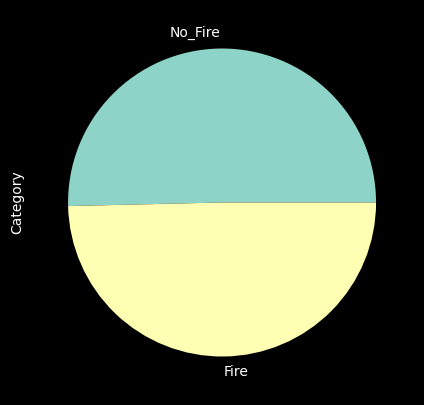

In [24]:
## Show the distribution of traning data
train_data['Category'].value_counts().plot.pie(figsize=(5,5))
plt.show()

### Visualize some images in the dataset

Text(0.5, 1.0, 'No_Fire')

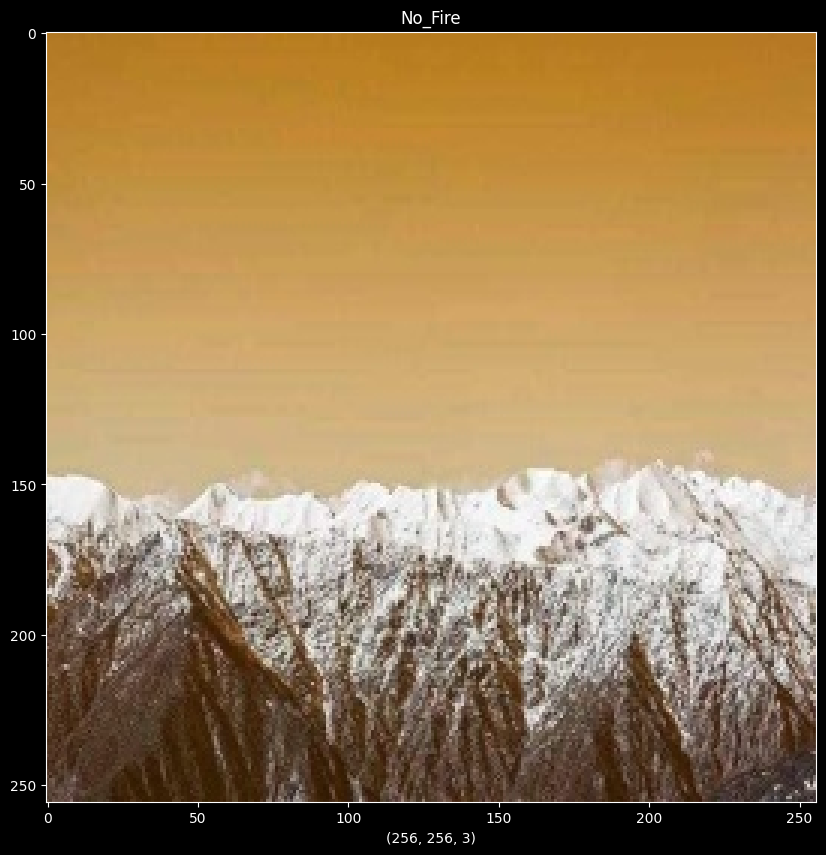

In [25]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_data["Files"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_data["Category"][0])

Text(0.5, 1.0, 'Fire')

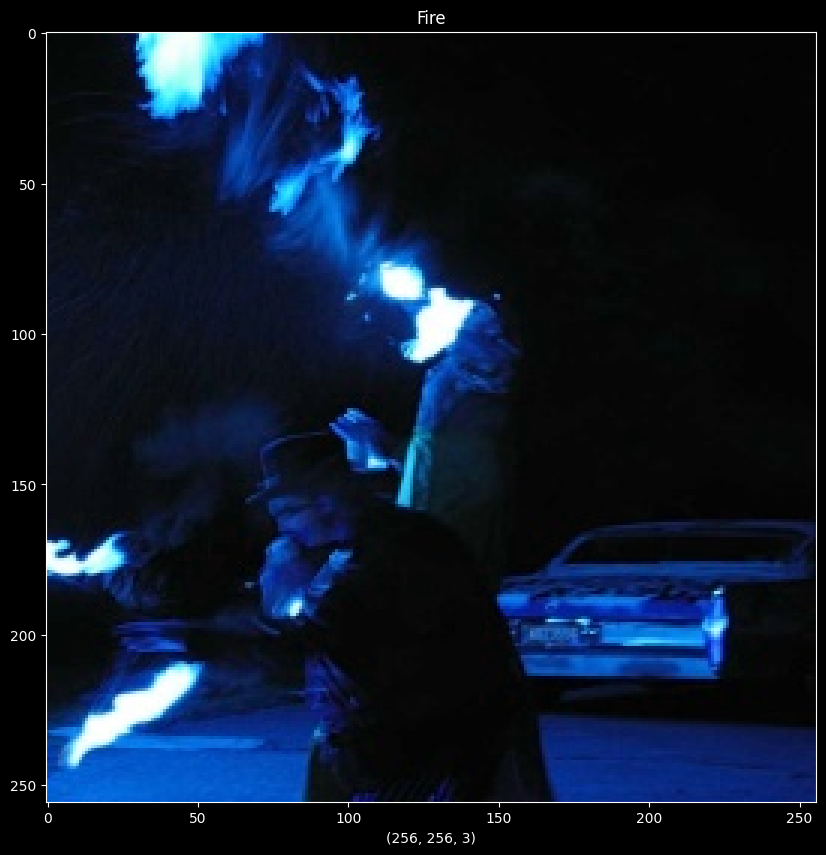

In [26]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_data["Files"][20])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_data["Category"][20])

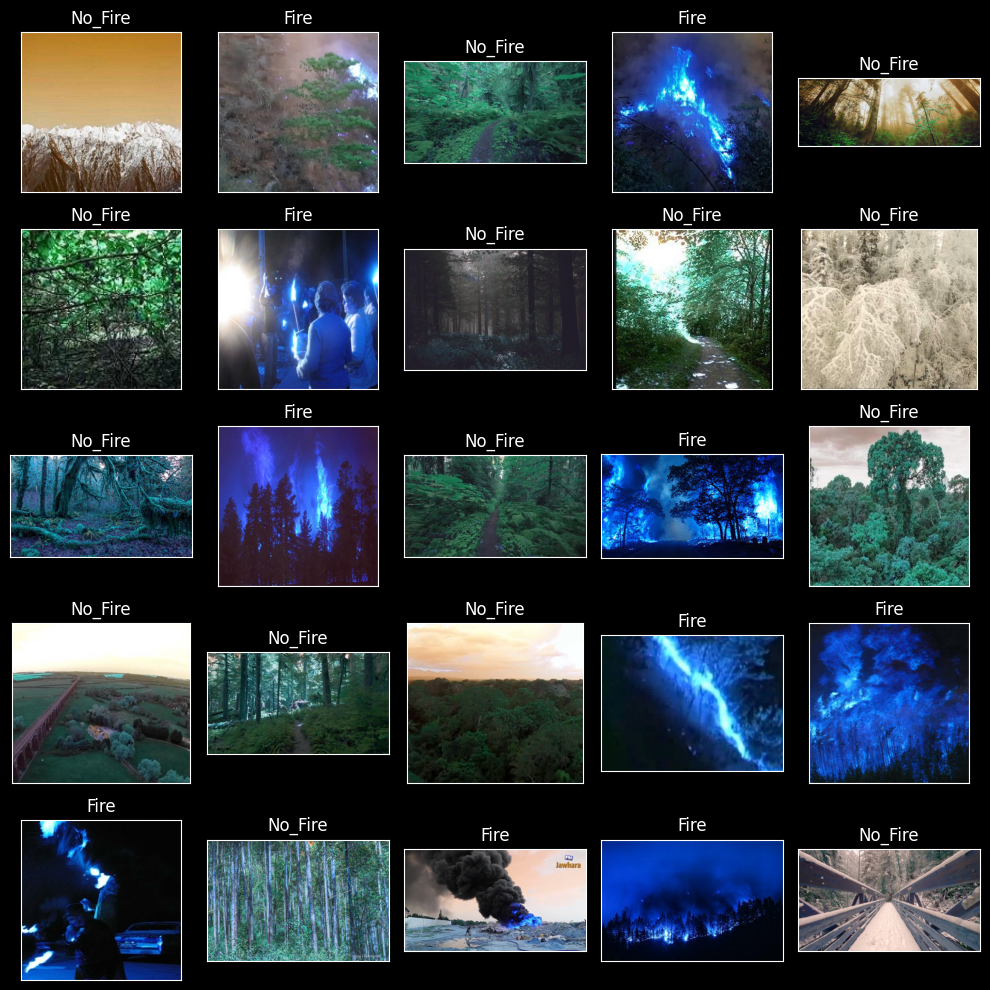

In [27]:
## Displaying some of the images in the dataset
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(train_data["Files"][i]))
    ax.set_title(train_data["Category"][i])
plt.tight_layout()
plt.show()

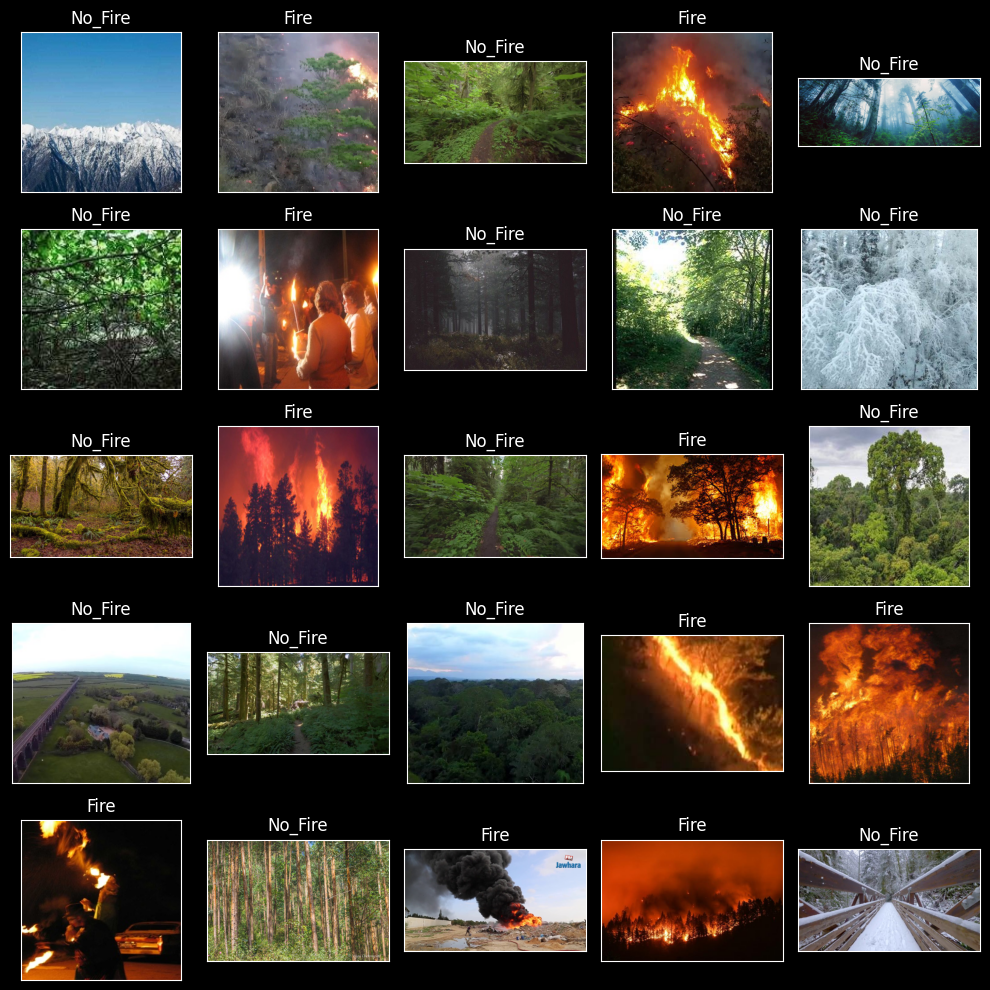

In [28]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    x = cv2.imread(train_data["Files"][i])
    x = cv2.cvtColor(x,cv2.COLOR_RGB2BGR)
    ax.imshow(x)
    ax.set_title(train_data["Category"][i])
plt.tight_layout()
plt.show()

### CNN Model Creation and Model Training

In [29]:

class FireImageExperiment:
    def __init__(self, num_layers=1, num_neurons=32, optimizer='sgd', batch_size=32):
        self.num_layers = num_layers
        self.num_neurons = num_neurons if isinstance(num_neurons, int) else num_neurons[-1]  # Use the last element if it's a list
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.model = self.build_model()
        tf.keras.backend.clear_session()

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Flatten(input_shape=(256, 256, 3)))  # Assuming images are 256x256 pixels with 3 channels (RGB)

        for _ in range(self.num_layers):
            model.add(layers.Dense(self.num_neurons, activation='relu'))

        model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation

        model.compile(optimizer=self.optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

    def train(self, train_generator, validation_generator, epochs=5, early_stopping=None):
        history = self.model.fit(train_generator,
                                 epochs=epochs, 
                                 validation_data=validation_generator,
                                 callbacks=early_stopping)
        return history

    def evaluate(self, test_generator):
        test_loss, test_acc = self.model.evaluate(test_generator)
        return test_loss, test_acc

    def plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = list(range(1, len(acc) + 1))  # Convert range to list

        fig = go.Figure()

        # Add traces
        fig.add_trace(go.Scatter(x=epochs, y=acc, mode='lines+markers', name='Training Accuracy'))
        fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy'))
        fig.update_layout(title='Training and Validation Accuracy',
                          xaxis_title='Epochs',
                          yaxis_title='Accuracy',
                          legend=dict(x=0, y=1, traceorder='normal'))

        fig.show()


In [30]:

# Set batch size
batch_size = 32

def data_preprocess(train_df, test_df):
    # Define image data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Files',
        y_col='Category',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='Files',
        y_col='Category',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return train_generator, test_generator

# Assuming train_data and test_data are the DataFrames containing the training and testing data respectively
train_generator, test_generator = data_preprocess(train_data, test_data)


Found 6479 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.


### Experiment 1 : Vary Number of Layers

2024-03-23 14:21:31.294209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 14:21:31.298473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 14:21:31.301614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/15


2024-03-23 14:21:32.211865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 14:21:32.968266: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3fb2ec4190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 14:21:32.968305: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-23 14:21:32.980269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2024-03-23 14:21:33.056287: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.8324

2024-03-23 14:22:14.226968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 57s 278ms/step - loss: 0.4886 - accuracy: 0.8324 - val_loss: 0.3058 - val_accuracy: 0.8662
Epoch 2/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3159 - accuracy: 0.8707 - val_loss: 0.2799 - val_accuracy: 0.8819
Epoch 3/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2812 - accuracy: 0.8895 - val_loss: 0.2704 - val_accuracy: 0.8843
Epoch 4/15
203/203 [==============================] - 56s 274ms/step - loss: 0.2670 - accuracy: 0.8907 - val_loss: 0.2530 - val_accuracy: 0.8981
Epoch 5/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2508 - accuracy: 0.8991 - val_loss: 0.2582 - val_accuracy: 0.8971
Epoch 6/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2428 - accuracy: 0.9045 - val_loss: 0.2467 - val_accuracy: 0.9052
Epoch 7/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2298 - accuracy: 0.9129 - val_loss: 0.2298 - val_accuracy: 0.9

2024-03-23 14:35:15.475826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 234ms/step - loss: 0.2247 - accuracy: 0.9119


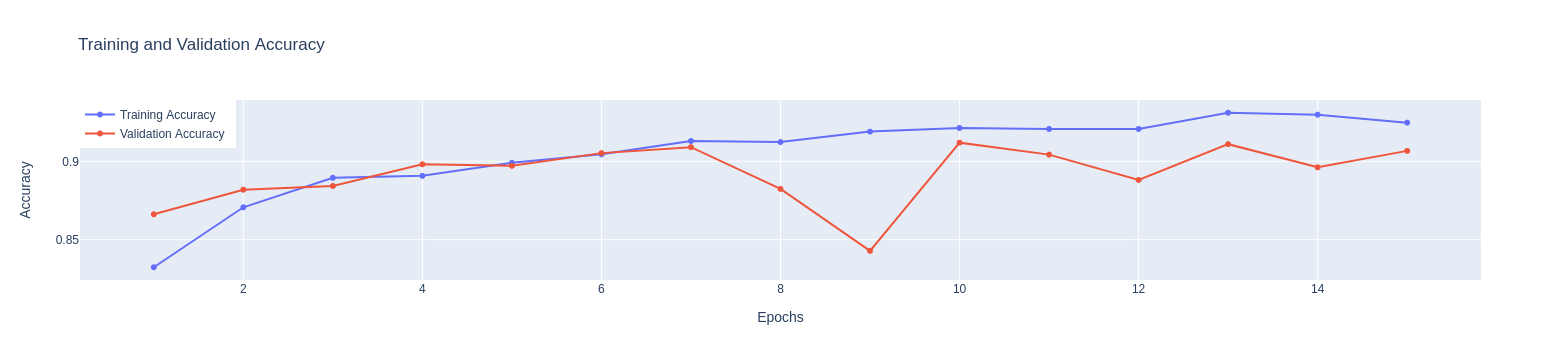

Epoch 1/15


2024-03-23 14:35:31.372491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8068

2024-03-23 14:36:12.721549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 57s 280ms/step - loss: 0.4474 - accuracy: 0.8068 - val_loss: 0.3074 - val_accuracy: 0.8733
Epoch 2/15
203/203 [==============================] - 57s 281ms/step - loss: 0.3168 - accuracy: 0.8737 - val_loss: 0.2790 - val_accuracy: 0.8843
Epoch 3/15
203/203 [==============================] - 54s 269ms/step - loss: 0.2869 - accuracy: 0.8825 - val_loss: 0.2552 - val_accuracy: 0.8852
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2731 - accuracy: 0.8889 - val_loss: 0.2882 - val_accuracy: 0.8819
Epoch 5/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2572 - accuracy: 0.8981 - val_loss: 0.2830 - val_accuracy: 0.8938
Epoch 6/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2460 - accuracy: 0.8995 - val_loss: 0.2628 - val_accuracy: 0.8881
Epoch 7/15
203/203 [==============================] - 54s 269ms/step - loss: 0.2361 - accuracy: 0.9048 - val_loss: 0.2979 - val_accuracy: 0.8

2024-03-23 14:49:19.256284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 229ms/step - loss: 0.2341 - accuracy: 0.9114


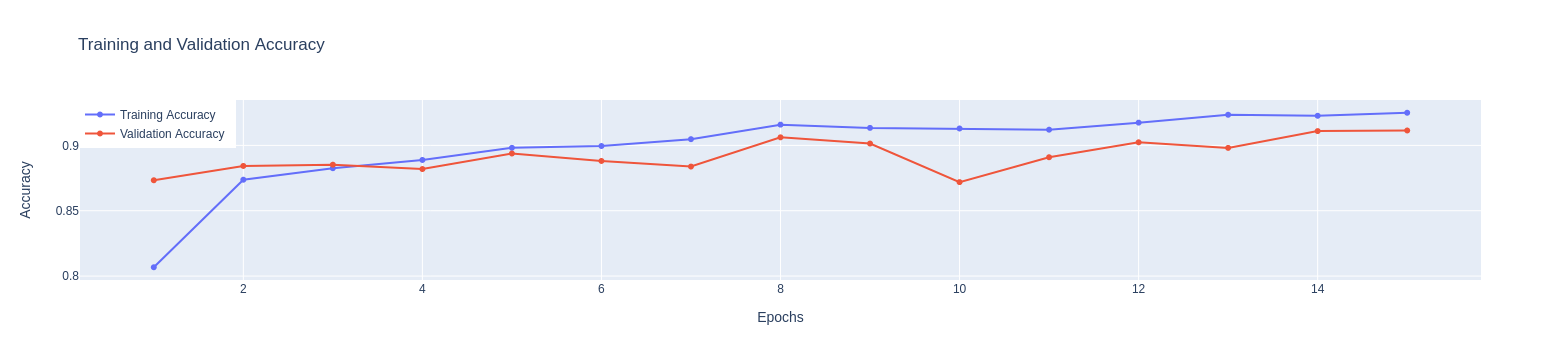

Epoch 1/15


2024-03-23 14:49:34.666679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8031

2024-03-23 14:50:14.734714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 55s 268ms/step - loss: 0.4483 - accuracy: 0.8031 - val_loss: 0.3230 - val_accuracy: 0.8662
Epoch 2/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3434 - accuracy: 0.8562 - val_loss: 0.3495 - val_accuracy: 0.8595
Epoch 3/15
203/203 [==============================] - 55s 269ms/step - loss: 0.3228 - accuracy: 0.8717 - val_loss: 0.2960 - val_accuracy: 0.8881
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2787 - accuracy: 0.8873 - val_loss: 0.2549 - val_accuracy: 0.8886
Epoch 5/15
203/203 [==============================] - 55s 266ms/step - loss: 0.2668 - accuracy: 0.8938 - val_loss: 0.4285 - val_accuracy: 0.7800
Epoch 6/15
203/203 [==============================] - 54s 265ms/step - loss: 0.2510 - accuracy: 0.9001 - val_loss: 0.2476 - val_accuracy: 0.8957
Epoch 7/15
203/203 [==============================] - 57s 279ms/step - loss: 0.2453 - accuracy: 0.9046 - val_loss: 0.2561 - val_accuracy: 0.8

2024-03-23 15:03:21.772094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 224ms/step - loss: 0.2919 - accuracy: 0.8771


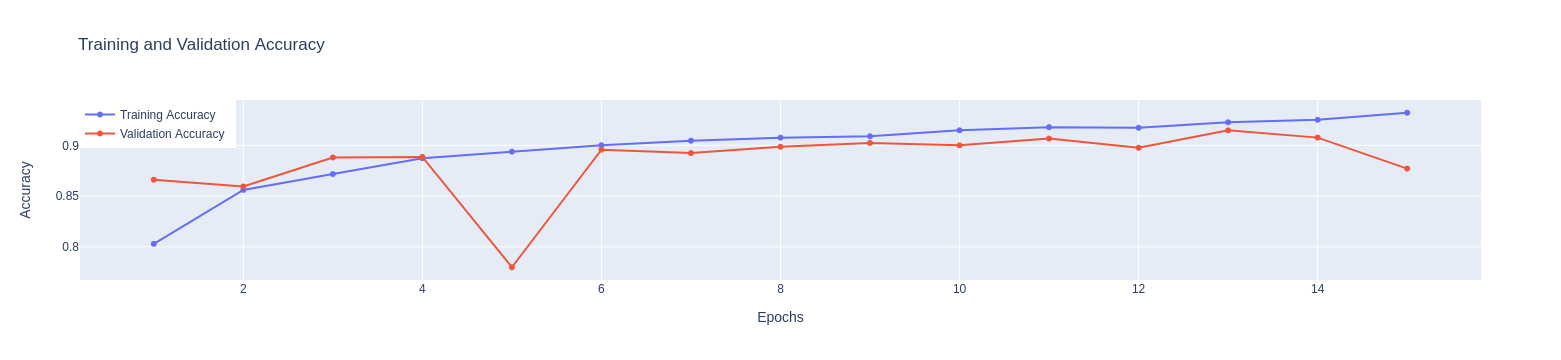

Epoch 1/15


2024-03-23 15:03:37.521142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8188

2024-03-23 15:04:18.124342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 272ms/step - loss: 0.4187 - accuracy: 0.8188 - val_loss: 0.2920 - val_accuracy: 0.8729
Epoch 2/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3187 - accuracy: 0.8753 - val_loss: 0.2719 - val_accuracy: 0.8852
Epoch 3/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2835 - accuracy: 0.8832 - val_loss: 0.2676 - val_accuracy: 0.8962
Epoch 4/15
203/203 [==============================] - 55s 274ms/step - loss: 0.2580 - accuracy: 0.8915 - val_loss: 0.2844 - val_accuracy: 0.8881
Epoch 5/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2578 - accuracy: 0.8986 - val_loss: 0.2834 - val_accuracy: 0.8829
Epoch 6/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2414 - accuracy: 0.9020 - val_loss: 0.2696 - val_accuracy: 0.8929
Epoch 7/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2324 - accuracy: 0.9097 - val_loss: 0.2388 - val_accuracy: 0.8

2024-03-23 15:17:48.725752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 234ms/step - loss: 0.2198 - accuracy: 0.9138


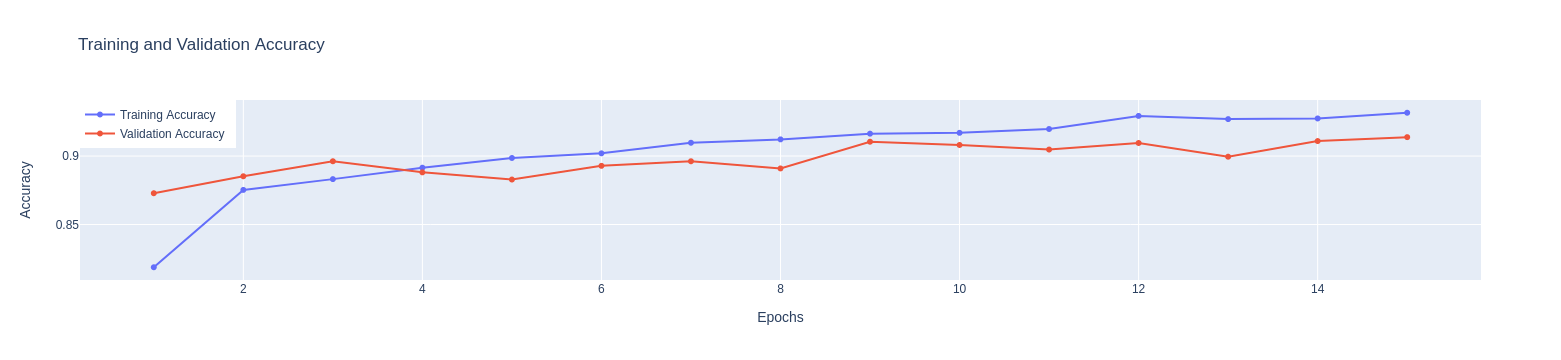

Epoch 1/15


2024-03-23 15:18:04.515386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7947

2024-03-23 15:18:48.553265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 60s 289ms/step - loss: 0.5523 - accuracy: 0.7947 - val_loss: 0.5158 - val_accuracy: 0.8286
Epoch 2/15
203/203 [==============================] - 55s 270ms/step - loss: 0.4366 - accuracy: 0.8611 - val_loss: 0.4056 - val_accuracy: 0.8667
Epoch 3/15
203/203 [==============================] - 54s 268ms/step - loss: 0.3854 - accuracy: 0.8682 - val_loss: 0.3834 - val_accuracy: 0.8576
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.3366 - accuracy: 0.8852 - val_loss: 0.3142 - val_accuracy: 0.8881
Epoch 5/15
203/203 [==============================] - 55s 270ms/step - loss: 0.3042 - accuracy: 0.8909 - val_loss: 0.3200 - val_accuracy: 0.8876
Epoch 6/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2857 - accuracy: 0.8960 - val_loss: 0.2915 - val_accuracy: 0.8890
Epoch 7/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2631 - accuracy: 0.9012 - val_loss: 0.2628 - val_accuracy: 0.9

2024-03-23 15:31:50.112083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 228ms/step - loss: 0.2849 - accuracy: 0.8933


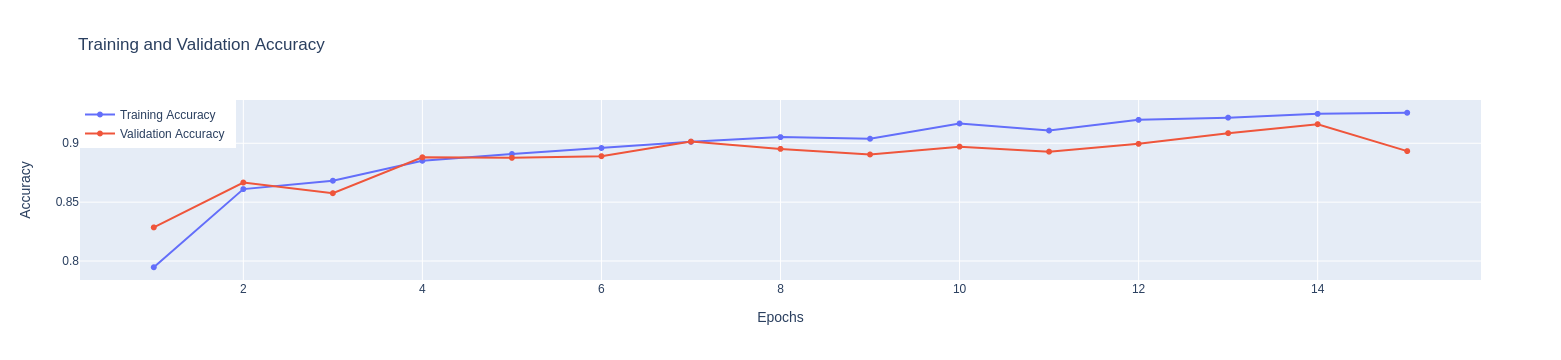

In [31]:

# Run experiments
results = []

count = 1

# Experiment 1: Vary numbers of layers
for num_layers in range(1, 6):
    exp = FireImageExperiment(num_layers=num_layers, num_neurons=32, optimizer='sgd', batch_size=batch_size)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = exp.train(train_generator, test_generator, epochs=15, early_stopping=[early_stopping])
    test_loss, test_acc = exp.evaluate(test_generator)
    results.append({'Experiment': count,
                    'NumLayers': exp.num_layers,
                    'NumNeurons': exp.num_neurons,
                    'Optimizer': exp.optimizer,
                    'BatchSize': exp.batch_size,
                    'TestLoss': test_loss,
                    'TestAccuracy': test_acc})
    count += 1

    exp.plot_history(history)


### Experiment 2: Vary numbers of neurons in a single hidden layer

Epoch 1/15


2024-03-23 15:32:13.160237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.8149

2024-03-23 15:32:53.488777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 271ms/step - loss: 0.4526 - accuracy: 0.8149 - val_loss: 0.3381 - val_accuracy: 0.8576
Epoch 2/15
203/203 [==============================] - 55s 272ms/step - loss: 0.3260 - accuracy: 0.8680 - val_loss: 0.3285 - val_accuracy: 0.8667
Epoch 3/15
203/203 [==============================] - 55s 269ms/step - loss: 0.3057 - accuracy: 0.8778 - val_loss: 0.2718 - val_accuracy: 0.8838
Epoch 4/15
203/203 [==============================] - 54s 266ms/step - loss: 0.2802 - accuracy: 0.8892 - val_loss: 0.2675 - val_accuracy: 0.8900
Epoch 5/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2567 - accuracy: 0.8974 - val_loss: 0.2484 - val_accuracy: 0.8971
Epoch 6/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2556 - accuracy: 0.8954 - val_loss: 0.2773 - val_accuracy: 0.8924
Epoch 7/15
203/203 [==============================] - 58s 287ms/step - loss: 0.2390 - accuracy: 0.9108 - val_loss: 0.2445 - val_accuracy: 0.9

2024-03-23 15:45:56.700685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 230ms/step - loss: 0.2899 - accuracy: 0.8924


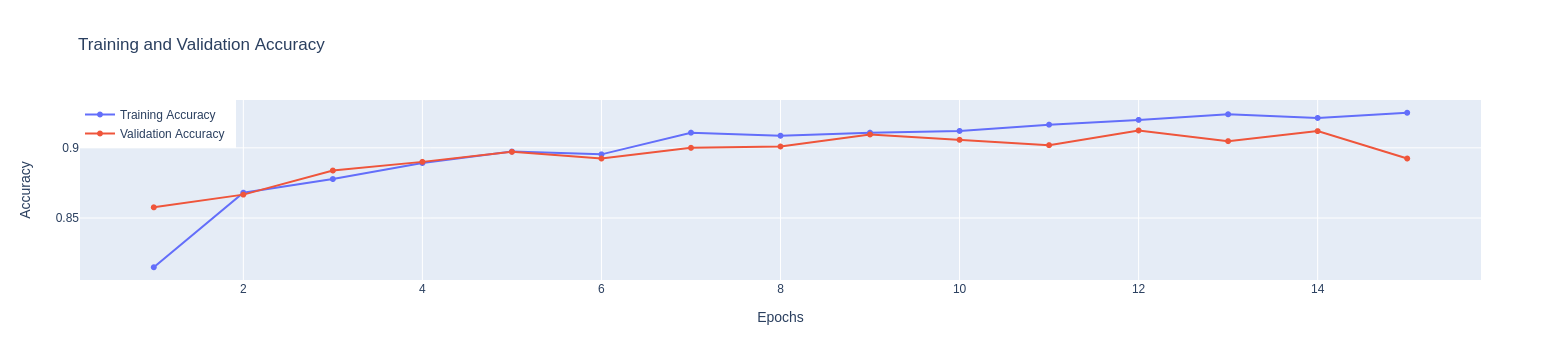

Epoch 1/15


2024-03-23 15:46:12.113120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8152

2024-03-23 15:46:53.044327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 273ms/step - loss: 0.4449 - accuracy: 0.8152 - val_loss: 0.3241 - val_accuracy: 0.8657
Epoch 2/15
203/203 [==============================] - 55s 269ms/step - loss: 0.3140 - accuracy: 0.8764 - val_loss: 0.3051 - val_accuracy: 0.8724
Epoch 3/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2916 - accuracy: 0.8836 - val_loss: 0.3277 - val_accuracy: 0.8695
Epoch 4/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2563 - accuracy: 0.9035 - val_loss: 0.3106 - val_accuracy: 0.8533
Epoch 5/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2459 - accuracy: 0.9038 - val_loss: 0.2413 - val_accuracy: 0.9000
Epoch 6/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2427 - accuracy: 0.9054 - val_loss: 0.2801 - val_accuracy: 0.8981
Epoch 7/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2299 - accuracy: 0.9094 - val_loss: 0.2351 - val_accuracy: 0.9

2024-03-23 15:59:58.583661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 228ms/step - loss: 0.2129 - accuracy: 0.9233


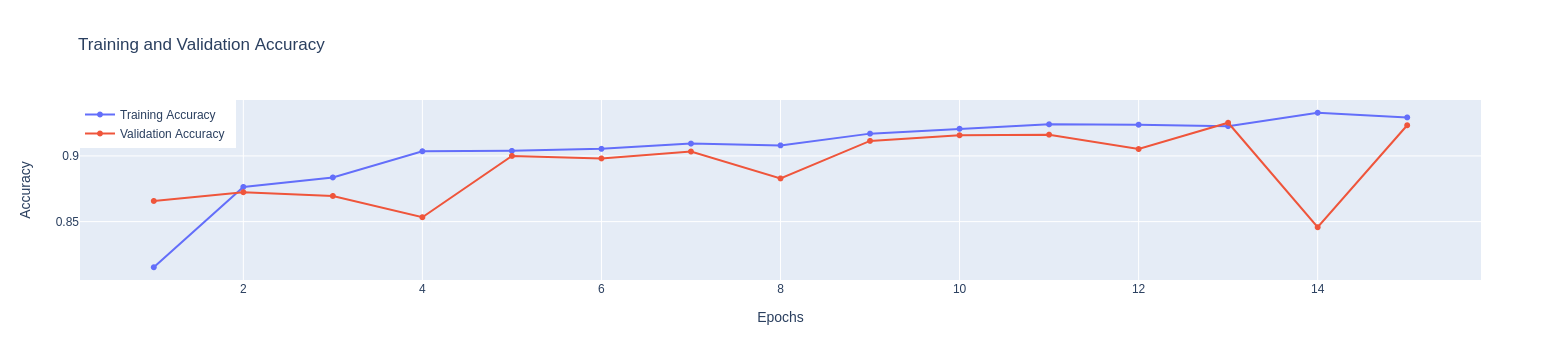

Epoch 1/15


2024-03-23 16:00:13.861819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.8092

2024-03-23 16:00:54.351951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 271ms/step - loss: 0.5344 - accuracy: 0.8092 - val_loss: 0.4791 - val_accuracy: 0.7743
Epoch 2/15
203/203 [==============================] - 55s 269ms/step - loss: 0.3310 - accuracy: 0.8660 - val_loss: 0.2996 - val_accuracy: 0.8710
Epoch 3/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2916 - accuracy: 0.8795 - val_loss: 0.2566 - val_accuracy: 0.8805
Epoch 4/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2731 - accuracy: 0.8913 - val_loss: 0.3770 - val_accuracy: 0.8252
Epoch 5/15
203/203 [==============================] - 54s 265ms/step - loss: 0.2510 - accuracy: 0.8984 - val_loss: 0.2610 - val_accuracy: 0.8962
Epoch 6/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2406 - accuracy: 0.9054 - val_loss: 0.2359 - val_accuracy: 0.9076
Epoch 7/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2334 - accuracy: 0.9082 - val_loss: 0.2457 - val_accuracy: 0.9

2024-03-23 16:10:14.441287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 231ms/step - loss: 0.2359 - accuracy: 0.9076


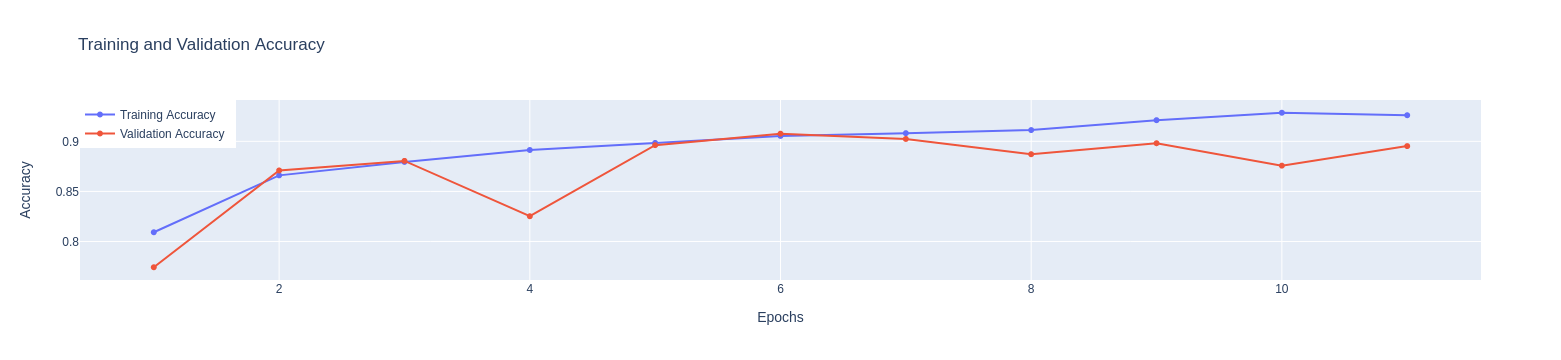

Epoch 1/15


2024-03-23 16:10:29.992438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8203

2024-03-23 16:11:11.569015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 57s 277ms/step - loss: 0.4817 - accuracy: 0.8203 - val_loss: 0.2786 - val_accuracy: 0.8786
Epoch 2/15
203/203 [==============================] - 54s 265ms/step - loss: 0.3092 - accuracy: 0.8731 - val_loss: 0.2687 - val_accuracy: 0.8890
Epoch 3/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2764 - accuracy: 0.8884 - val_loss: 0.3502 - val_accuracy: 0.8652
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2552 - accuracy: 0.8972 - val_loss: 0.2637 - val_accuracy: 0.8829
Epoch 5/15
203/203 [==============================] - 54s 269ms/step - loss: 0.2399 - accuracy: 0.9034 - val_loss: 0.3548 - val_accuracy: 0.8757
Epoch 6/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2313 - accuracy: 0.9097 - val_loss: 0.2239 - val_accuracy: 0.9090
Epoch 7/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2216 - accuracy: 0.9100 - val_loss: 0.2260 - val_accuracy: 0.9

2024-03-23 16:20:34.862834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 231ms/step - loss: 0.2239 - accuracy: 0.9090


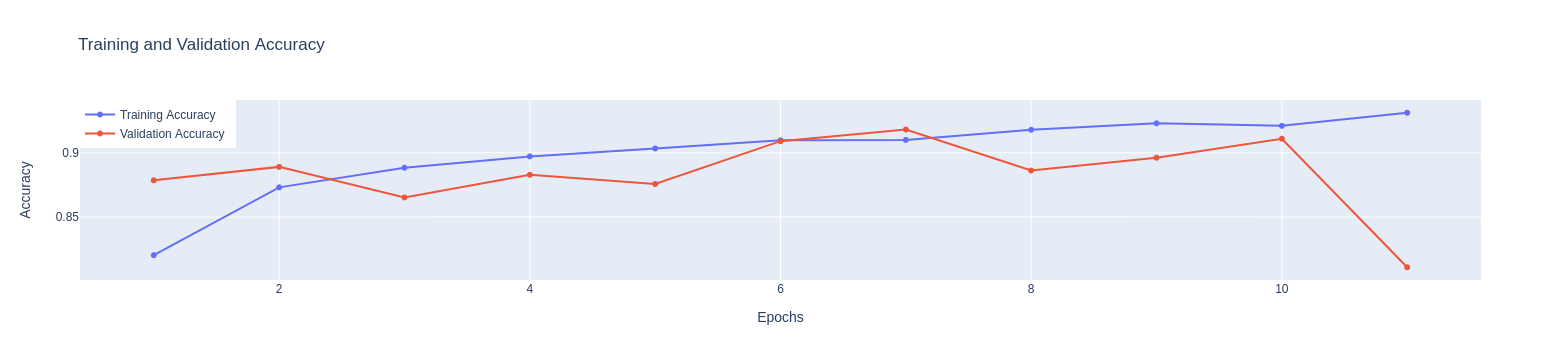

Epoch 1/15


2024-03-23 16:20:50.357362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.8279

2024-03-23 16:21:30.440139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 271ms/step - loss: 0.5038 - accuracy: 0.8279 - val_loss: 0.2886 - val_accuracy: 0.8729
Epoch 2/15
203/203 [==============================] - 54s 265ms/step - loss: 0.3132 - accuracy: 0.8670 - val_loss: 0.2606 - val_accuracy: 0.8848
Epoch 3/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2735 - accuracy: 0.8916 - val_loss: 0.2730 - val_accuracy: 0.8767
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2549 - accuracy: 0.8989 - val_loss: 0.2372 - val_accuracy: 0.9038
Epoch 5/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2443 - accuracy: 0.9020 - val_loss: 0.2262 - val_accuracy: 0.9090
Epoch 6/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2393 - accuracy: 0.9071 - val_loss: 0.2338 - val_accuracy: 0.8995
Epoch 7/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2133 - accuracy: 0.9173 - val_loss: 0.2216 - val_accuracy: 0.9

2024-03-23 16:34:33.195914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 230ms/step - loss: 0.1936 - accuracy: 0.9276


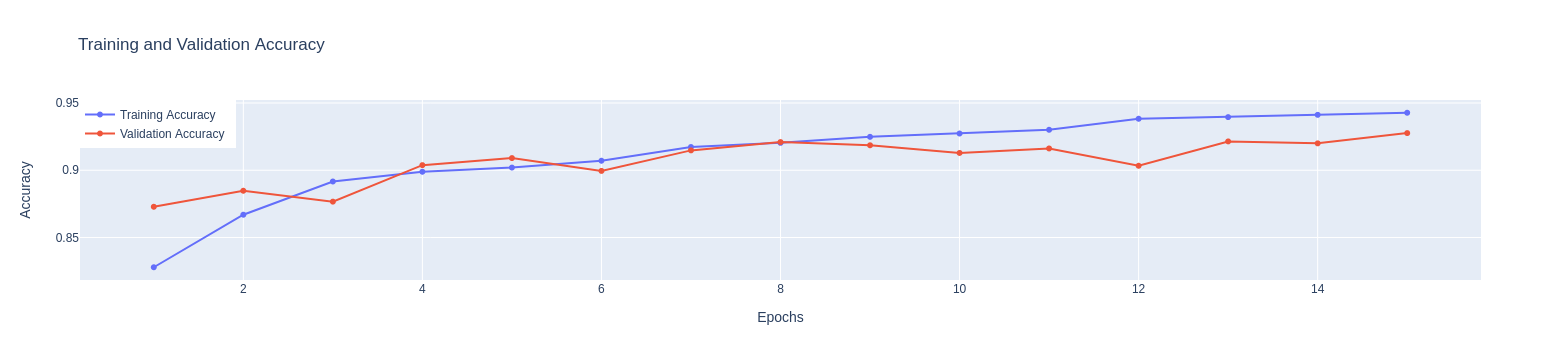

Epoch 1/15


2024-03-23 16:34:48.667651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8250

2024-03-23 16:35:28.774360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 57s 276ms/step - loss: 0.4406 - accuracy: 0.8250 - val_loss: 0.3511 - val_accuracy: 0.8576
Epoch 2/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2987 - accuracy: 0.8813 - val_loss: 0.2576 - val_accuracy: 0.8886
Epoch 3/15
203/203 [==============================] - 54s 269ms/step - loss: 0.2746 - accuracy: 0.8861 - val_loss: 0.3278 - val_accuracy: 0.8643
Epoch 4/15
203/203 [==============================] - 55s 274ms/step - loss: 0.2554 - accuracy: 0.8998 - val_loss: 0.2362 - val_accuracy: 0.9043
Epoch 5/15
203/203 [==============================] - 57s 279ms/step - loss: 0.2254 - accuracy: 0.9113 - val_loss: 0.2298 - val_accuracy: 0.9105
Epoch 6/15
203/203 [==============================] - 57s 282ms/step - loss: 0.2208 - accuracy: 0.9139 - val_loss: 0.2645 - val_accuracy: 0.8924
Epoch 7/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2155 - accuracy: 0.9156 - val_loss: 0.2443 - val_accuracy: 0.8

2024-03-23 16:48:38.462050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 233ms/step - loss: 0.1997 - accuracy: 0.9305


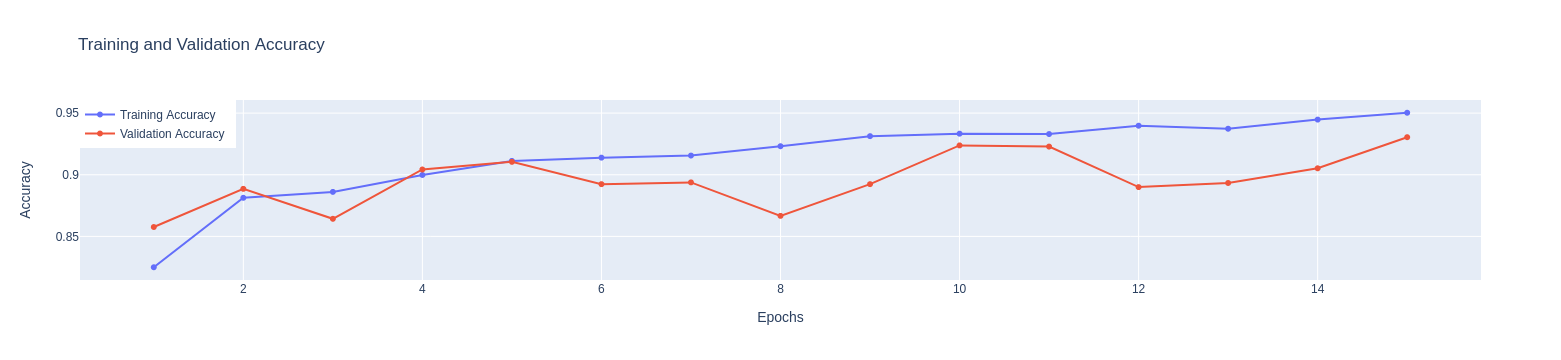

Epoch 1/15


2024-03-23 16:48:54.125816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8220

2024-03-23 16:49:34.970020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 58s 285ms/step - loss: 0.5300 - accuracy: 0.8220 - val_loss: 0.2745 - val_accuracy: 0.8838
Epoch 2/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2978 - accuracy: 0.8719 - val_loss: 0.3550 - val_accuracy: 0.8590
Epoch 3/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2623 - accuracy: 0.8944 - val_loss: 0.3618 - val_accuracy: 0.8252
Epoch 4/15
203/203 [==============================] - 55s 273ms/step - loss: 0.2382 - accuracy: 0.9054 - val_loss: 0.2723 - val_accuracy: 0.8962
Epoch 5/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2278 - accuracy: 0.9088 - val_loss: 0.2741 - val_accuracy: 0.8933
Epoch 6/15
203/203 [==============================] - 55s 273ms/step - loss: 0.2114 - accuracy: 0.9162 - val_loss: 0.2460 - val_accuracy: 0.9038
Epoch 7/15
203/203 [==============================] - 55s 273ms/step - loss: 0.2059 - accuracy: 0.9202 - val_loss: 0.2256 - val_accuracy: 0.9

2024-03-23 17:02:52.396343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 227ms/step - loss: 0.2166 - accuracy: 0.9286


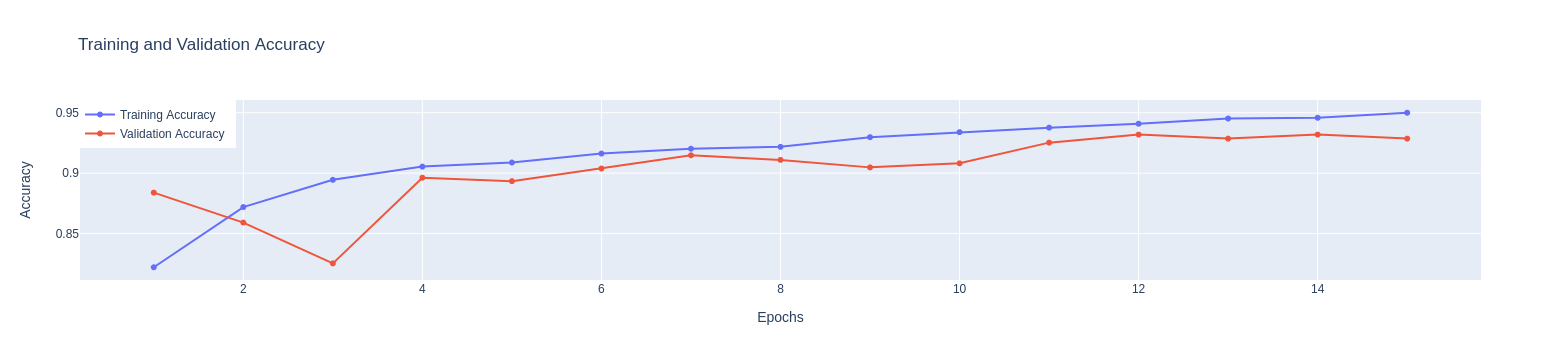

In [32]:
# Experiment 2: Vary numbers of neurons in a single hidden layer
for num_neurons in [32, 64, 128, 256, 512, 1024, 2048]:
    exp = FireImageExperiment(num_layers=1, num_neurons=num_neurons, optimizer='sgd', batch_size=batch_size)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = exp.train(train_generator, test_generator, epochs=15, early_stopping=[early_stopping])
    test_loss, test_acc = exp.evaluate(test_generator)
    results.append({'Experiment': count,
                    'NumLayers': exp.num_layers,
                    'NumNeurons': exp.num_neurons,
                    'Optimizer': exp.optimizer,
                    'BatchSize': exp.batch_size,
                    'TestLoss': test_loss,
                    'TestAccuracy': test_acc})
    count += 1

    exp.plot_history(history)


### Experiment 3: Varying batch sizes

Epoch 1/15


2024-03-23 17:03:07.752796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8152

2024-03-23 17:03:47.245705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 55s 264ms/step - loss: 0.4267 - accuracy: 0.8152 - val_loss: 0.3093 - val_accuracy: 0.8752
Epoch 2/15
203/203 [==============================] - 55s 271ms/step - loss: 0.3169 - accuracy: 0.8719 - val_loss: 0.3521 - val_accuracy: 0.8519
Epoch 3/15
203/203 [==============================] - 54s 266ms/step - loss: 0.2976 - accuracy: 0.8799 - val_loss: 0.3342 - val_accuracy: 0.8686
Epoch 4/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2802 - accuracy: 0.8872 - val_loss: 0.2752 - val_accuracy: 0.8886
Epoch 5/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2633 - accuracy: 0.8916 - val_loss: 0.2531 - val_accuracy: 0.8900
Epoch 6/15
203/203 [==============================] - 54s 266ms/step - loss: 0.2468 - accuracy: 0.9015 - val_loss: 0.3694 - val_accuracy: 0.8681
Epoch 7/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2482 - accuracy: 0.8978 - val_loss: 0.2474 - val_accuracy: 0.8

2024-03-23 17:16:42.924860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 227ms/step - loss: 0.2238 - accuracy: 0.9133


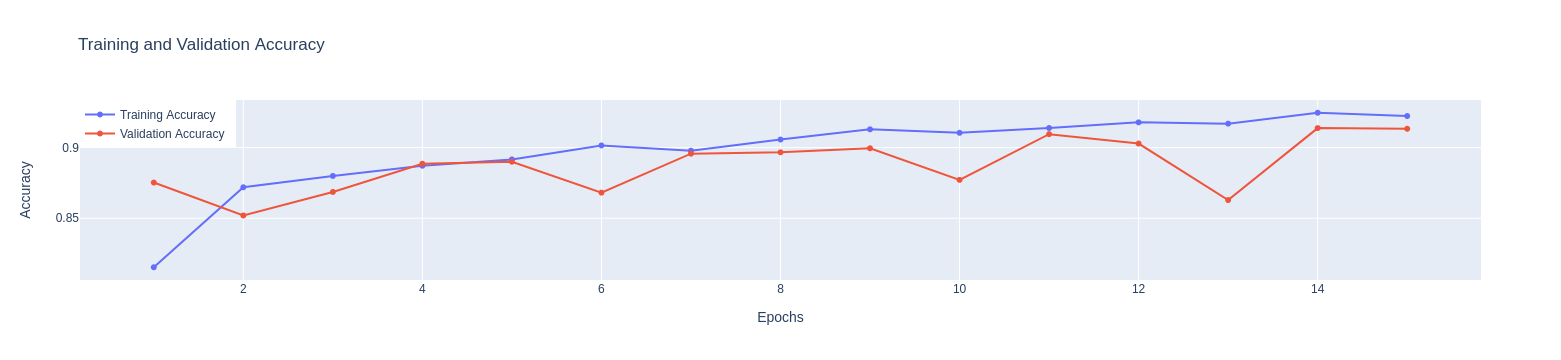

Epoch 1/15


2024-03-23 17:16:58.200132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.7960

2024-03-23 17:17:38.861844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 272ms/step - loss: 0.4452 - accuracy: 0.7960 - val_loss: 0.3569 - val_accuracy: 0.8538
Epoch 2/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3296 - accuracy: 0.8662 - val_loss: 0.5581 - val_accuracy: 0.7957
Epoch 3/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2944 - accuracy: 0.8862 - val_loss: 0.2715 - val_accuracy: 0.8810
Epoch 4/15
203/203 [==============================] - 58s 288ms/step - loss: 0.2765 - accuracy: 0.8895 - val_loss: 0.2587 - val_accuracy: 0.8890
Epoch 5/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2647 - accuracy: 0.8927 - val_loss: 0.2480 - val_accuracy: 0.8948
Epoch 6/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2487 - accuracy: 0.9021 - val_loss: 0.2556 - val_accuracy: 0.8938
Epoch 7/15
203/203 [==============================] - 54s 265ms/step - loss: 0.2311 - accuracy: 0.9086 - val_loss: 0.4768 - val_accuracy: 0.7

2024-03-23 17:30:37.040707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 229ms/step - loss: 0.2197 - accuracy: 0.9162


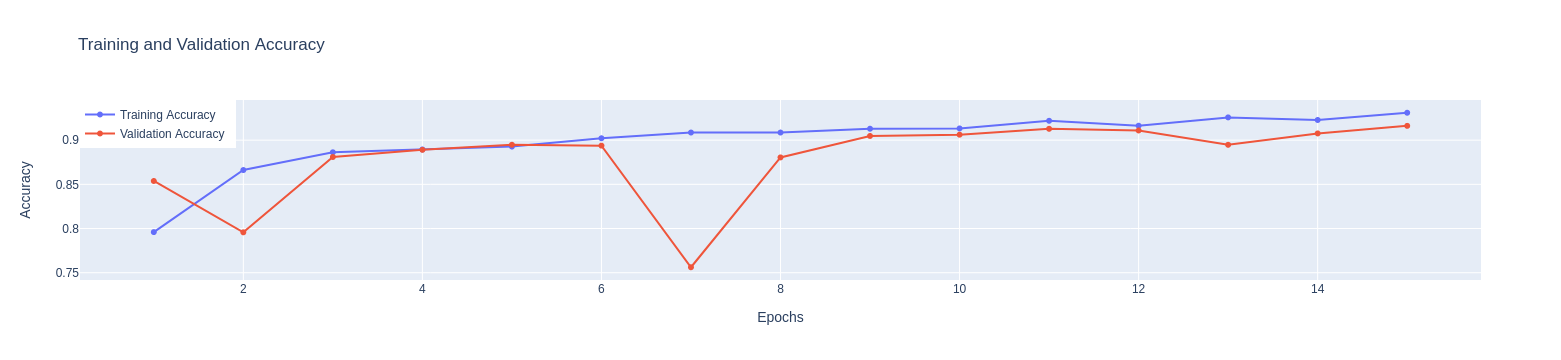

Epoch 1/15


2024-03-23 17:30:52.427252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8220

2024-03-23 17:31:31.902049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 55s 265ms/step - loss: 0.4239 - accuracy: 0.8220 - val_loss: 0.3479 - val_accuracy: 0.8486
Epoch 2/15
203/203 [==============================] - 54s 267ms/step - loss: 0.3168 - accuracy: 0.8699 - val_loss: 0.2865 - val_accuracy: 0.8776
Epoch 3/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2916 - accuracy: 0.8788 - val_loss: 0.2990 - val_accuracy: 0.8800
Epoch 4/15
203/203 [==============================] - 55s 268ms/step - loss: 0.2679 - accuracy: 0.8929 - val_loss: 0.2510 - val_accuracy: 0.8886
Epoch 5/15
203/203 [==============================] - 54s 265ms/step - loss: 0.2491 - accuracy: 0.8978 - val_loss: 0.2437 - val_accuracy: 0.8990
Epoch 6/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2434 - accuracy: 0.9023 - val_loss: 0.2995 - val_accuracy: 0.8771
Epoch 7/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2341 - accuracy: 0.9102 - val_loss: 0.2435 - val_accuracy: 0.9

2024-03-23 17:44:26.321383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 224ms/step - loss: 0.2253 - accuracy: 0.9067


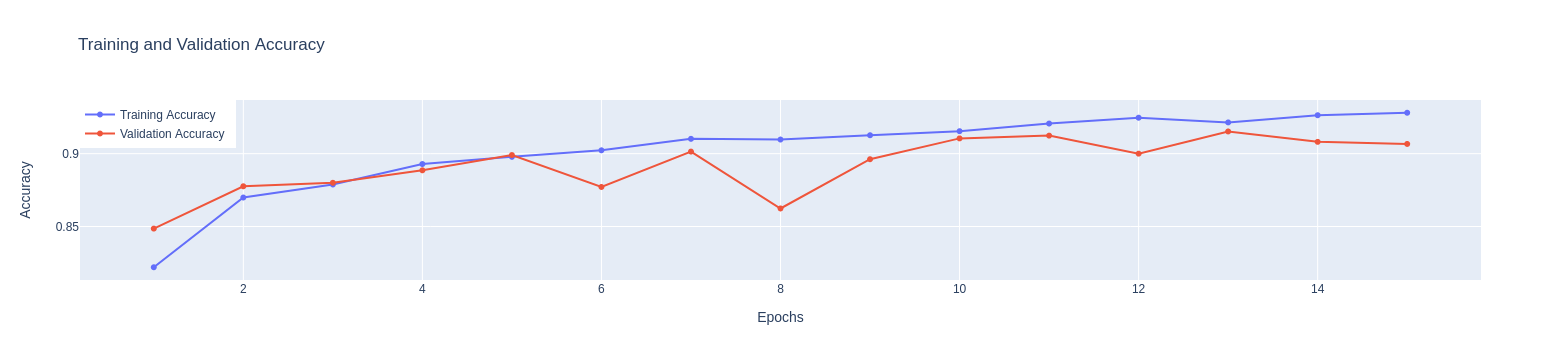

Epoch 1/15


2024-03-23 17:44:41.433752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.8007

2024-03-23 17:45:21.424322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 55s 268ms/step - loss: 0.4469 - accuracy: 0.8007 - val_loss: 0.3639 - val_accuracy: 0.8543
Epoch 2/15
203/203 [==============================] - 54s 265ms/step - loss: 0.3336 - accuracy: 0.8656 - val_loss: 0.2921 - val_accuracy: 0.8824
Epoch 3/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3101 - accuracy: 0.8768 - val_loss: 0.2618 - val_accuracy: 0.8848
Epoch 4/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2748 - accuracy: 0.8900 - val_loss: 0.4099 - val_accuracy: 0.8576
Epoch 5/15
203/203 [==============================] - 53s 263ms/step - loss: 0.2600 - accuracy: 0.8966 - val_loss: 0.2535 - val_accuracy: 0.8933
Epoch 6/15
203/203 [==============================] - 54s 266ms/step - loss: 0.2515 - accuracy: 0.8995 - val_loss: 0.2465 - val_accuracy: 0.9000
Epoch 7/15
203/203 [==============================] - 54s 263ms/step - loss: 0.2384 - accuracy: 0.9074 - val_loss: 0.2257 - val_accuracy: 0.9

2024-03-23 17:58:12.645475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 228ms/step - loss: 0.2167 - accuracy: 0.9171


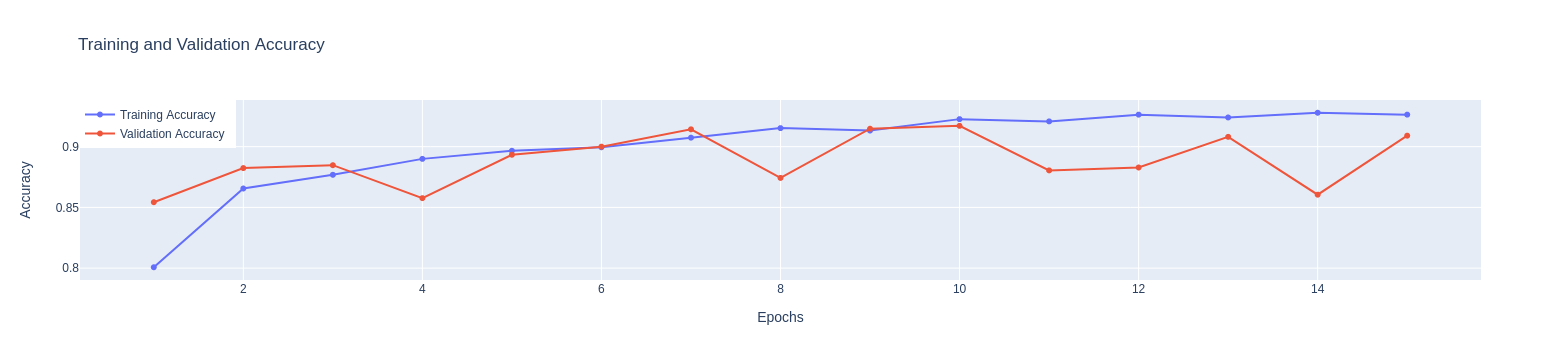

In [33]:
# Experiment 3: Varying batch sizes
for batch_size in [32, 64, 128, 256]:
    exp = FireImageExperiment(num_layers=5, num_neurons=32, optimizer='sgd', batch_size=batch_size)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = exp.train(train_generator, test_generator, epochs=15, early_stopping=[early_stopping])
    test_loss, test_acc = exp.evaluate(test_generator)
    results.append({'Experiment': count,
                    'NumLayers': exp.num_layers,
                    'NumNeurons': exp.num_neurons,
                    'Optimizer': exp.optimizer,
                    'BatchSize': exp.batch_size,
                    'TestLoss': test_loss,
                    'TestAccuracy': test_acc})
    count += 1

    exp.plot_history(history)


### Experiment 4: Varying number of layers and neurons in each layer

Epoch 1/15


2024-03-23 17:58:28.013910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.8075

2024-03-23 17:59:07.941269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 55s 270ms/step - loss: 0.4908 - accuracy: 0.8075 - val_loss: 0.4284 - val_accuracy: 0.8157
Epoch 2/15
203/203 [==============================] - 56s 274ms/step - loss: 0.3145 - accuracy: 0.8727 - val_loss: 0.2999 - val_accuracy: 0.8695
Epoch 3/15
203/203 [==============================] - 56s 274ms/step - loss: 0.2868 - accuracy: 0.8832 - val_loss: 0.2537 - val_accuracy: 0.8952
Epoch 4/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2653 - accuracy: 0.8943 - val_loss: 0.2493 - val_accuracy: 0.8990
Epoch 5/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2538 - accuracy: 0.9026 - val_loss: 0.2408 - val_accuracy: 0.9019
Epoch 6/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2403 - accuracy: 0.9038 - val_loss: 0.3167 - val_accuracy: 0.8562
Epoch 7/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2327 - accuracy: 0.9097 - val_loss: 0.2371 - val_accuracy: 0.9

2024-03-23 18:12:06.743255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 232ms/step - loss: 0.2446 - accuracy: 0.9090


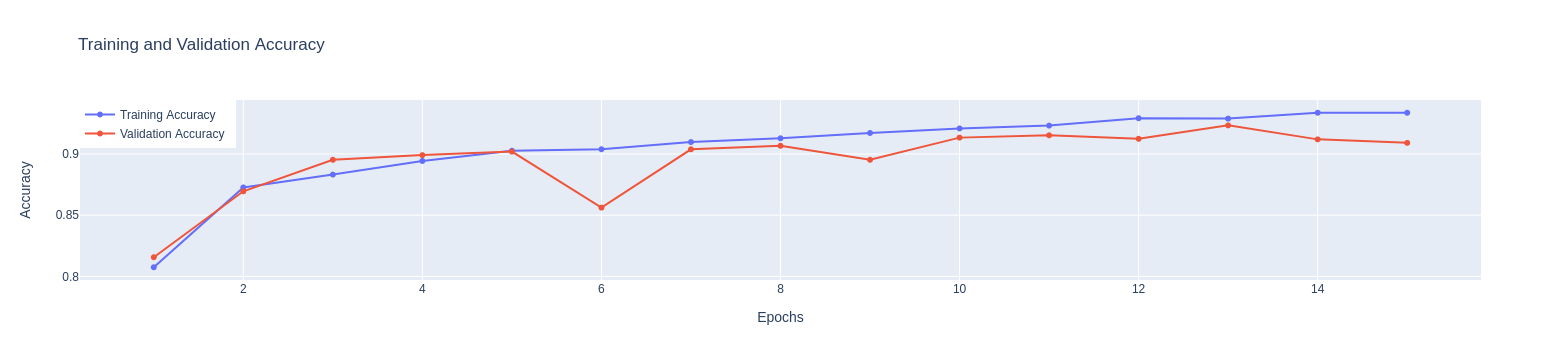

Epoch 1/15


2024-03-23 18:12:22.436005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8015

2024-03-23 18:13:03.404480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 56s 274ms/step - loss: 0.4397 - accuracy: 0.8015 - val_loss: 0.3258 - val_accuracy: 0.8667
Epoch 2/15
203/203 [==============================] - 54s 266ms/step - loss: 0.3211 - accuracy: 0.8682 - val_loss: 0.2982 - val_accuracy: 0.8771
Epoch 3/15
203/203 [==============================] - 54s 263ms/step - loss: 0.2902 - accuracy: 0.8836 - val_loss: 0.3319 - val_accuracy: 0.8548
Epoch 4/15
203/203 [==============================] - 54s 268ms/step - loss: 0.2570 - accuracy: 0.8958 - val_loss: 0.2412 - val_accuracy: 0.8919
Epoch 5/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2504 - accuracy: 0.9032 - val_loss: 0.2407 - val_accuracy: 0.9029
Epoch 6/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2333 - accuracy: 0.9085 - val_loss: 0.2341 - val_accuracy: 0.9043
Epoch 7/15
203/203 [==============================] - 54s 267ms/step - loss: 0.2277 - accuracy: 0.9082 - val_loss: 0.2367 - val_accuracy: 0.9

2024-03-23 18:26:08.093552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 16s 236ms/step - loss: 0.2339 - accuracy: 0.9114


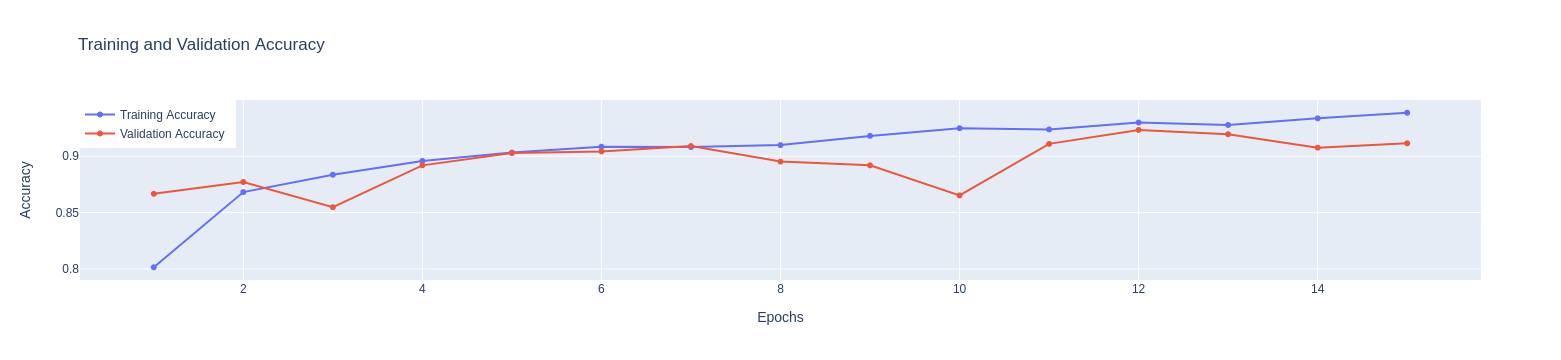

Epoch 1/15


2024-03-23 18:26:24.200128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8078

2024-03-23 18:27:05.527435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 57s 277ms/step - loss: 0.4283 - accuracy: 0.8078 - val_loss: 0.4321 - val_accuracy: 0.8248
Epoch 2/15
203/203 [==============================] - 55s 268ms/step - loss: 0.3165 - accuracy: 0.8739 - val_loss: 0.4610 - val_accuracy: 0.8305
Epoch 3/15
203/203 [==============================] - 55s 269ms/step - loss: 0.2849 - accuracy: 0.8832 - val_loss: 0.3391 - val_accuracy: 0.8333
Epoch 4/15
203/203 [==============================] - 54s 264ms/step - loss: 0.2516 - accuracy: 0.9009 - val_loss: 0.3797 - val_accuracy: 0.8681
Epoch 5/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2411 - accuracy: 0.9031 - val_loss: 0.3453 - val_accuracy: 0.8448
Epoch 6/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2346 - accuracy: 0.9057 - val_loss: 0.2246 - val_accuracy: 0.9095
Epoch 7/15
203/203 [==============================] - 55s 271ms/step - loss: 0.2183 - accuracy: 0.9148 - val_loss: 0.2625 - val_accuracy: 0.8

2024-03-23 18:40:07.159972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 16s 239ms/step - loss: 0.2204 - accuracy: 0.9233


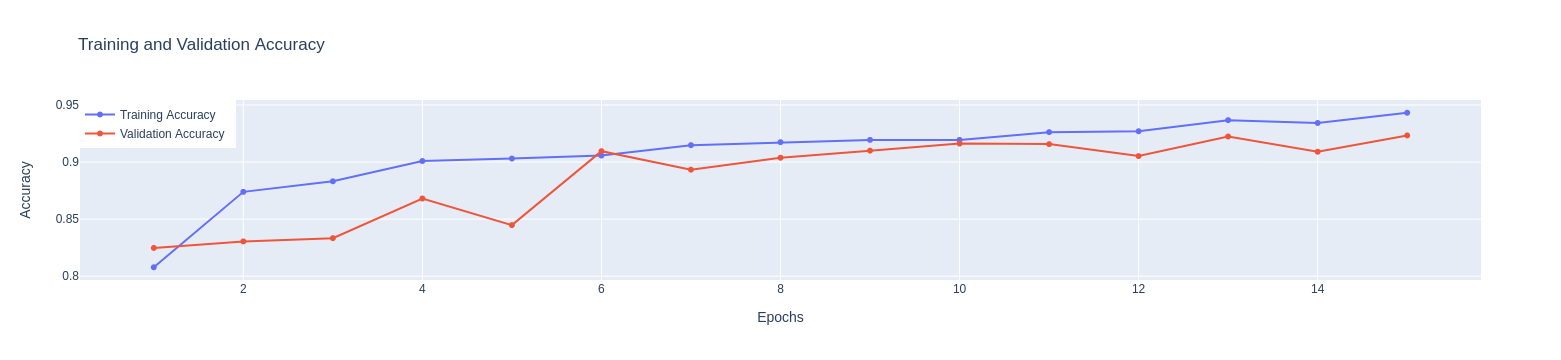

In [34]:
# Experiment 4: Varying number of layers and neurons in each layer
layer_variants = [[1024, 128], [1024, 512, 128], [2048, 1024, 128]]
for variant in layer_variants:
    exp = FireImageExperiment(num_layers=len(variant), num_neurons=variant, optimizer='sgd', batch_size=batch_size)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = exp.train(train_generator, test_generator, epochs=15, early_stopping=[early_stopping])
    test_loss, test_acc = exp.evaluate(test_generator)
    results.append({'Experiment': count,
                    'NumLayers': exp.num_layers,
                    'NumNeurons': exp.num_neurons,
                    'Optimizer': exp.optimizer,
                    'BatchSize': exp.batch_size,
                    'TestLoss': test_loss,
                    'TestAccuracy': test_acc})
    count += 1

    exp.plot_history(history)


### Display Best Performing Model

In [38]:

# Display sorted results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='TestAccuracy', ascending=False)
print("\nResults:")
print(df_results)



Results:
    Experiment  NumLayers  NumNeurons Optimizer  BatchSize  TestLoss  \
10          11          1        1024       sgd         32  0.199728   
11          12          1        2048       sgd         32  0.216575   
9           10          1         512       sgd         32  0.193630   
6            7          1          64       sgd         32  0.212887   
18          19          3         128       sgd        256  0.220431   
15          16          5          32       sgd        256  0.216707   
13          14          5          32       sgd         64  0.219662   
3            4          4          32       sgd         32  0.219809   
12          13          5          32       sgd         32  0.223791   
0            1          1          32       sgd         32  0.224702   
1            2          2          32       sgd         32  0.234135   
17          18          3         128       sgd        256  0.233880   
8            9          1         256       sgd       

### Create a Model with best performing hyperparameters

In [41]:
# Print the top performing model
best_model = df_results.head(1)
print(best_model)

    Experiment  NumLayers  NumNeurons Optimizer  BatchSize  TestLoss  \
10          11          1        1024       sgd         32  0.199728   

    TestAccuracy  
10      0.930476  


In [31]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

Epoch 1/15


2024-03-23 18:44:55.256332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.8149

2024-03-23 18:45:41.288682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


203/203 [==============================] - 64s 312ms/step - loss: 0.5037 - accuracy: 0.8149 - val_loss: 0.2824 - val_accuracy: 0.8729
Epoch 2/15
203/203 [==============================] - 54s 268ms/step - loss: 0.3017 - accuracy: 0.8790 - val_loss: 0.2915 - val_accuracy: 0.8767
Epoch 3/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2756 - accuracy: 0.8890 - val_loss: 0.2538 - val_accuracy: 0.8986
Epoch 4/15
203/203 [==============================] - 56s 275ms/step - loss: 0.2566 - accuracy: 0.9006 - val_loss: 0.2331 - val_accuracy: 0.9110
Epoch 5/15
203/203 [==============================] - 55s 272ms/step - loss: 0.2357 - accuracy: 0.9089 - val_loss: 0.2221 - val_accuracy: 0.9119
Epoch 6/15
203/203 [==============================] - 55s 270ms/step - loss: 0.2190 - accuracy: 0.9157 - val_loss: 0.2418 - val_accuracy: 0.8981
Epoch 7/15
203/203 [==============================] - 56s 277ms/step - loss: 0.2192 - accuracy: 0.9165 - val_loss: 0.2268 - val_accuracy: 0.9

2024-03-23 18:58:51.745244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 15s 226ms/step - loss: 0.2145 - accuracy: 0.9257


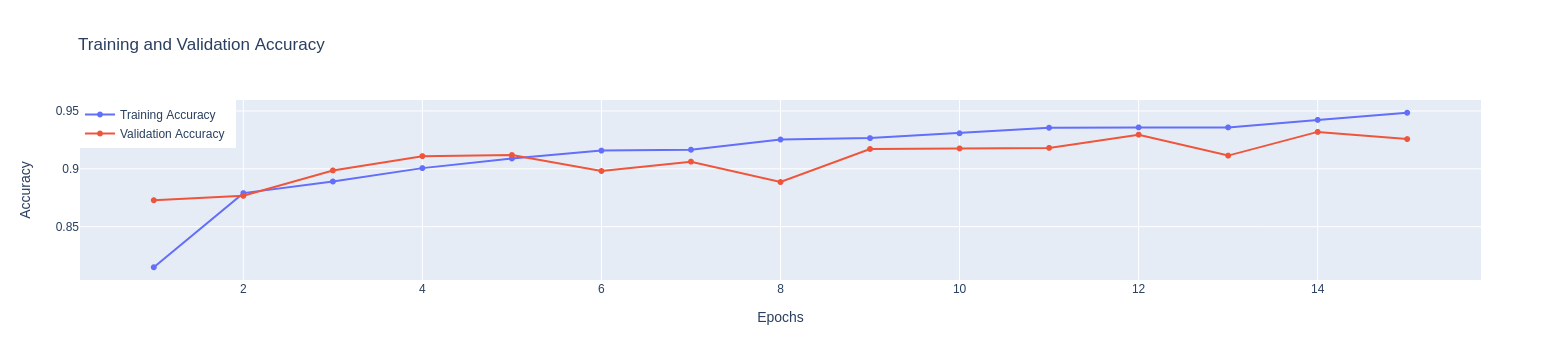

In [43]:
best_exp = FireImageExperiment(num_layers=int(best_model.NumLayers), num_neurons=int(best_model.NumNeurons), optimizer='sgd', batch_size=int(best_model.BatchSize))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_exp.train(train_generator, test_generator, epochs=15, early_stopping=[early_stopping])
test_loss, test_acc = best_exp.evaluate(test_generator)

model = best_exp.model
best_exp.plot_history(history)

### Save the Best performing Model in S3

In [44]:
# Save the model
import joblib

model_save_path = f's3://{bucket}/image_recognition/'
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

INFO:tensorflow:Assets written to: s3://sagemaker-ap-south-1-020036392760/image_recognition/assets
Model saved at s3://sagemaker-ap-south-1-020036392760/image_recognition/


### Load the Model

In [33]:
# Load the model and then run inference
model_load = tf.keras.models.load_model(model_save_path)

2024-03-23 19:38:00.429283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:38:00.434120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:38:00.437290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [34]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 201,328,641
Trainable params: 201,328,641
Non-trainable params: 0
_________________________________________________________________


### Prediction for images not in the dataset

In [35]:
# Define image size
IMG_SIZE = (256, 256)

# Define class labels
CLASS_LABELS = list(train_generator.class_indices.keys())

# Function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Function to make predictions
def predict(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model_load.predict(preprocessed_img)
    class_idx = int(np.round(prediction)[0][0])  # Convert prediction to class index (0 or 1)
    class_label = CLASS_LABELS[class_idx]
    return class_label

# Usage
image_path = "images/image.jpg"
prediction = predict(image_path)
print(f"The image is classified as: {prediction}")


1/1 [==============================] - 0s 161ms/step
The image is classified as: Fire


In [36]:
# Usage
image_path = "images/image2.jpg"
prediction = predict(image_path)
print(f"The image is classified as: {prediction}")


1/1 [==============================] - 0s 33ms/step
The image is classified as: No_Fire
